#### **Density Profile Comparisons**:

Notebook for calculation of 2D and 3D density profiles of galaxies, dark matter, and gas.

In [1]:
import numpy as np
import illustris_python as il
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
import seaborn as sns
import h5py
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology as colossus_cosmo
from colossus.halo import concentration
import emcee
import scipy
import sys

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

sns.set(style = "ticks")
pi = np.pi

from IPython.core.display import display, HTML

%config IPCompleter.greedy = True
%config InlineBackend.figure_format ='retina'

# basePath = '../Splashback-Research/TNG-100_3/outputs/'
# basePath_dark = '../Splashback-Research/TNG-100_3_Dark/outputs/'

# snap_dir_g = basePath+'snapdir_066/snap_066.0.hdf5'
# snap_dir_dark = basePath_dark+'snapdir_066/snap_066.0.hdf5'

basePath = '../Splashback-Research/TNG-300_3/outputs/'
basePath_dark = '../Splashback-Research/TNG-300_3_Dark/outputs/'

snap_dir_g = basePath+'snapdir_099/snap_099.0.hdf5'
snap_dir_dark = basePath_dark+'snapdir_099/snap_099.0.hdf5'

matching_cat_path = basePath+'subhalo_matching_to_dark.hdf5'

snapshot_ind = 99

# Load header file and halo group catalog
header = il.groupcat.loadHeader(basePath, snapshot_ind)
header_dark = il.groupcat.loadHeader(basePath_dark, snapshot_ind)

halo_grp_fields = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_M_Mean200', 
                   'Group_R_Crit200', 'Group_R_Mean200', 'GroupFirstSub']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields=halo_grp_fields)
halo_grp['has_gas'] = True

header_dark = il.groupcat.loadHeader(basePath_dark, snapshot_ind)
halo_grp_fields_dark = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_M_Mean200', 
                        'Group_R_Crit200', 'Group_R_Mean200', 'GroupFirstSub']
halo_grp_dark = il.groupcat.loadHalos(basePath_dark, snapshot_ind, fields=halo_grp_fields_dark)
halo_grp_dark['has_gas'] = False

# Obtain basic cosmological info and obtain conversion factors
redshift = header['Redshift']
H = cosmo.H(redshift)
H0 = cosmo.H(0)
h = H0.value/100
cosmo_col = colossus_cosmo.setCosmology('planck15');

# Define box boundary vector in Mpc (for period bcs)
boxsize = header['BoxSize'] # kpc/h
box_bounds = boxsize*np.ones(3)/1000

# Get DM Particle mass
with h5py.File(snap_dir_dark) as f:
    snap_dark = dict(f['Header'].attrs.items())

with h5py.File(snap_dir_g) as f:
    snap_g = dict(f['Header'].attrs.items())
    
dm_part_mass_dark = snap_dark['MassTable'][1]*10**10/h # Mass in solar mass
dm_part_mass = snap_g['MassTable'][1]*10**10/h

# Get subhalo matching catalog
with h5py.File(matching_cat_path) as f:
    subhalo_match = f['Snapshot_'+str(snapshot_ind)]['SubhaloIndexDark_LHaloTree'][()]

# Compute subhalo matching catalog index by dark files
subhalo_match_dark = -1*np.ones(header_dark['Nsubgroups_Total'], dtype=int)
subhalo_match_dark[subhalo_match[np.where(subhalo_match != -1)]] = np.argwhere(subhalo_match != -1).flatten()

print("Snapshot Num: "+str(snapshot_ind))
print("Snapshot Boxsize: "+str(boxsize)+" [kpc/h]")
print("Snapshot Redshift: "+str(redshift))
print("Total Number of Halos in Snapshot: "+str(halo_grp['count']))

Snapshot Num: 99
Snapshot Boxsize: 205000.0 [kpc/h]
Snapshot Redshift: 2.220446049250313e-16
Total Number of Halos in Snapshot: 377342


#### **Pick Subset of Halos to Analyze**:

Specify a subset of halos from TNG-100_3 and TNG-100_3_Dark catalogs to perform analysis on.

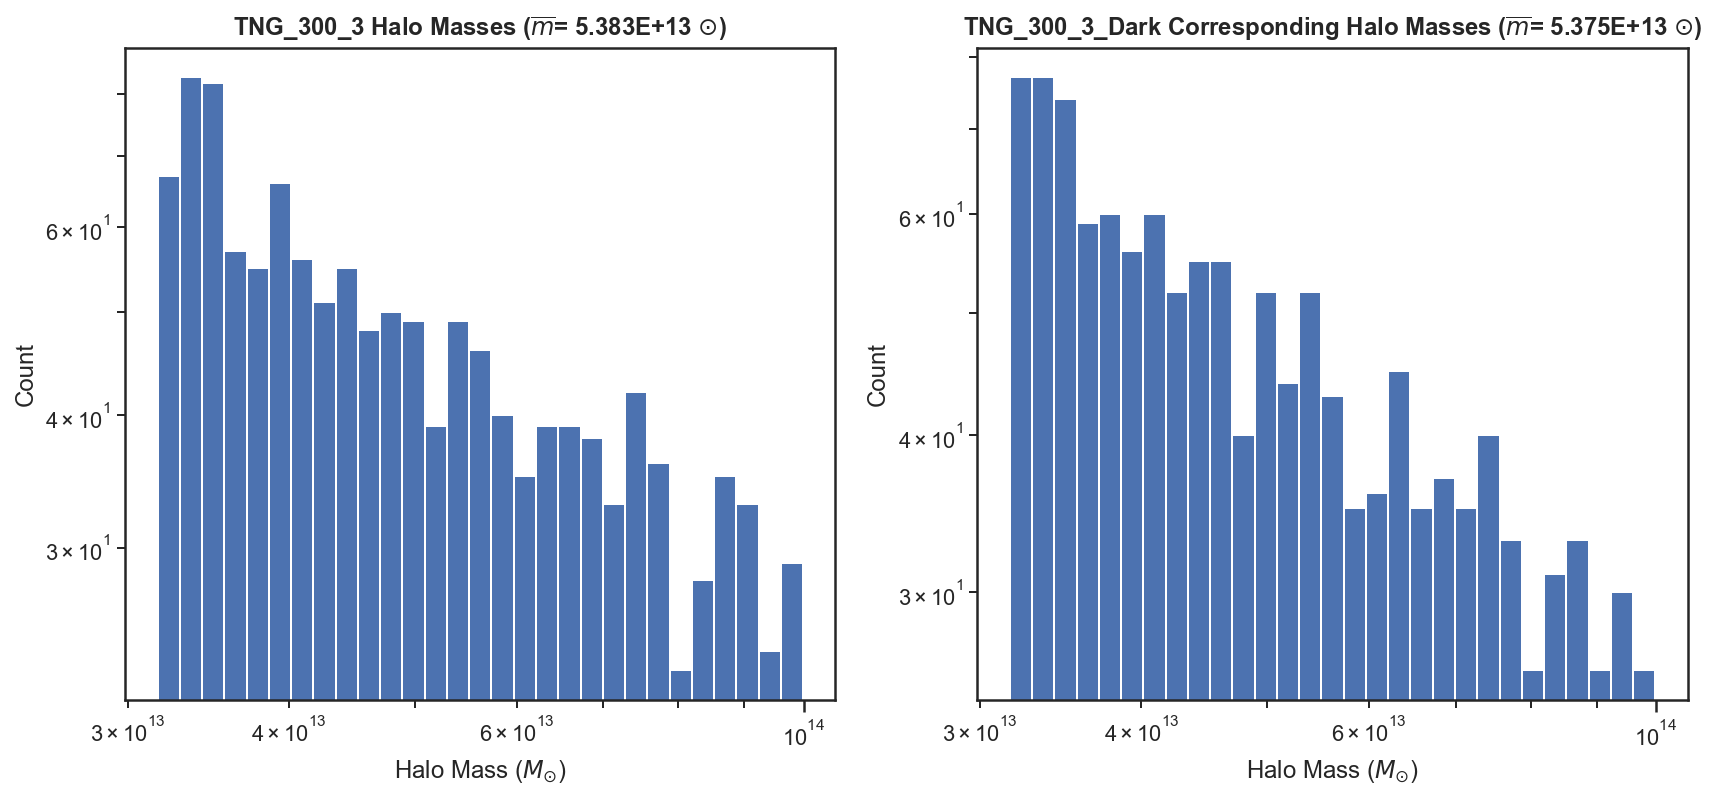

In [66]:
# get all profiles with halo mass between 10^13-10^14 solar mass in baryonic catalog
halo_masses = halo_grp['GroupMass']*10**10/h
halo_masses_dark = halo_grp_dark['GroupMass']*10**10/h

halo_indices = np.where((halo_masses >= 10**13.5) & 
                        (halo_masses <= 10**14))[0]

halo_indices_dark =  np.where((halo_masses_dark >= 10**13.5) & 
                        (halo_masses_dark <= 10**14))[0]

matched_ind = np.array([], dtype=int)


for halo_ind in halo_indices:
    
    # Consider only indices which have not yet been matched
    relevant_indices = np.setdiff1d(halo_indices_dark, matched_ind)
    
    # Get halo mass and find index of relevant indices which has dm halo mass closest
    halo_mass = halo_masses[halo_ind]
    optimal_ind = np.argmin(np.abs(halo_masses_dark[relevant_indices]-halo_mass))
    matched_ind = np.append(matched_ind, relevant_indices[optimal_ind])
    
    
halo_indices_dark = matched_ind

# halo_indices_dark = np.flip(halo_indices_dark)[36:]  

# best_ind = np.random.choice(halo_indices_dark, len(halo_indices), replace=False)
                            
# for i in range(10000):
    
#     ind_dark = np.random.choice(halo_indices_dark, len(halo_indices), replace=False)
    
#     delta_best = np.abs(np.mean(halo_masses)-np.mean(halo_masses_dark[best_ind]))
#     delta_cur = np.abs(np.mean(halo_masses)-np.mean(halo_masses_dark[ind_dark]))

#     if delta_cur < delta_best:
#         best_ind = ind_dark
        
# halo_indices_dark = best_ind

HALO_COUNT = len(halo_indices) # Number of halos selected for analysis

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
bins = np.logspace(np.min(np.log10(halo_masses[halo_indices])), 
                   np.max(np.log10(halo_masses[halo_indices])), 30)
bins = np.logspace(np.min(np.log10(halo_masses_dark[halo_indices_dark])), 
                   np.max(np.log10(halo_masses_dark[halo_indices_dark])), 30)

plt.hist(halo_masses[halo_indices], bins=bins)
title_str = r"TNG_300_3 Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses[halo_indices]))
plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
bins = np.logspace(np.min(np.log10(halo_masses_dark[halo_indices_dark])), 
                   np.max(np.log10(halo_masses_dark[halo_indices_dark])), 30)

plt.hist(halo_masses_dark[halo_indices_dark], bins=bins)
title_str = r"TNG_300_3_Dark Corresponding Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses_dark[halo_indices_dark]))

plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

##### **Load Particle Data (Dark):**

Load all particles within 2 Mpc of halo CM.

In [71]:
# Save Indices
np.save("../Splashback-Research/TNG-300_3_dark/outputs/full_positions_099/halo_indices_dark_mass_sel.npy", halo_indices_dark)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/halo_indices_mass_sel.npy", halo_indices)

In [72]:
def progress_bar(cur_val, final_val):
    """ 
    Function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [73]:
fields = ['Coordinates']
dm_coords_chunk = il.snapshot.loadSubset(basePath_dark, snapshot_ind, "dm", fields, sq=True)/1000

fields = ['Velocities']
dm_veloc_chunk = il.snapshot.loadSubset(basePath_dark, snapshot_ind, "dm", fields, sq=True)

In [75]:
halo_dm_pos = np.empty(HALO_COUNT, dtype=object)
halo_dm_veloc = np.empty(HALO_COUNT, dtype=object)

R_HALO = 5 # The maximum radius to collect particles about halo_cm

for i, halo_ind in enumerate(halo_indices_dark):
    
    progress_bar(i, HALO_COUNT)
    
    halo_cm = halo_grp_dark['GroupCM'][halo_ind]/1000

    # Before performing calculations, select particles within box around halo_cm
    box_filt = np.where((dm_coords_chunk.T[0] >= halo_cm[0]-R_HALO) & 
                      (dm_coords_chunk.T[0] <= halo_cm[0]+R_HALO) &
                      (dm_coords_chunk.T[1] >= halo_cm[1]-R_HALO) &
                      (dm_coords_chunk.T[1] <= halo_cm[1]+R_HALO) &
                      (dm_coords_chunk.T[2] >= halo_cm[2]-R_HALO) &
                      (dm_coords_chunk.T[2] <= halo_cm[2]+R_HALO)
                       )[0]

    dm_coords_filt = dm_coords_chunk[box_filt]
    dm_veloc_filt = dm_veloc_chunk[box_filt]
    
    # Compute radius from cm
    dev = dm_coords_filt-halo_cm

    # Account for halos which go over the boundary
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q

    # Keep only particles within r = R_HALO Mpc/h
    r = np.linalg.norm(dev, axis=1)  

    final_pos = dm_coords_filt[np.where(r < R_HALO)]
    final_veloc = dm_veloc_filt[np.where(r < R_HALO)]

    halo_dm_pos[i] = final_pos
    halo_dm_veloc[i] = final_veloc
    
    
    progress_bar(i+1, HALO_COUNT)

Progress: [------------------->] 100%

In [76]:
np.save("../Splashback-Research/TNG-300_3_dark/outputs/full_positions_099/dm_coords_dark_mass_sel.npy", halo_dm_pos)
np.save("../Splashback-Research/TNG-300_3_dark/outputs/full_positions_099/dm_veloc_dark_mass_sel.npy", halo_dm_veloc)

In [104]:
np.save("../Splashback-Research/TNG-300_3_dark/outputs/full_positions_099/dm_veloc_dark_mass_sel.npy", halo_dm_veloc)

In [109]:
np.save("../Splashback-Research/TNG-300_3_dark/outputs/full_positions_099/dm_veloc_dark_mass_sel.npy", halo_dm_veloc)

##### **Load Particle Data:**

Load all particles within 2 Mpc of halo CM.

In [77]:
fields = ['Coordinates']
dm_coords_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "dm", fields, sq=True)/1000

fields = ['Velocities']
dm_veloc_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "dm", fields, sq=True)

In [78]:
halo_dm_pos = np.empty(HALO_COUNT, dtype=object)
halo_dm_veloc = np.empty(HALO_COUNT, dtype=object)

R_HALO = 5 # The maximum radius to collect particles about halo_cm

for i, halo_ind in enumerate(halo_indices):
    
    progress_bar(i, HALO_COUNT)
    
    halo_cm = halo_grp['GroupCM'][halo_ind]/1000

    # Before performing calculations, select particles within box around halo_cm
    box_filt = np.where((dm_coords_chunk.T[0] >= halo_cm[0]-R_HALO) & 
                      (dm_coords_chunk.T[0] <= halo_cm[0]+R_HALO) &
                      (dm_coords_chunk.T[1] >= halo_cm[1]-R_HALO) &
                      (dm_coords_chunk.T[1] <= halo_cm[1]+R_HALO) &
                      (dm_coords_chunk.T[2] >= halo_cm[2]-R_HALO) &
                      (dm_coords_chunk.T[2] <= halo_cm[2]+R_HALO)
                       )[0]

    dm_coords_filt = dm_coords_chunk[box_filt]
    dm_veloc_filt = dm_veloc_chunk[box_filt]
    
    # Compute radius from cm
    dev = dm_coords_filt-halo_cm

    # Account for halos which go over the boundary
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q

    # Keep only particles within r = 2 Mpc/h
    r = np.linalg.norm(dev, axis=1)  

    final_pos = dm_coords_filt[np.where(r < R_HALO)]
    final_veloc = dm_veloc_filt[np.where(r < R_HALO)]
    
    halo_dm_veloc[i] = final_veloc
    halo_dm_pos[i] = final_pos
    
    
    progress_bar(i+1, HALO_COUNT)

Progress: [------------------->] 100%

In [79]:
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/dm_coords_mass_sel.npy", halo_dm_pos)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/dm_veloc_mass_sel.npy", halo_dm_veloc)

In [111]:
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/dm_veloc_mass_sel.npy", halo_dm_veloc)

In [80]:
fields = ['Coordinates']
gas_coords_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "gas", fields, sq=True)/1000


fields = ['Masses']
gas_mass_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "gas", fields, sq=True)/h*10**10

fields = ['Velocities']
gas_veloc_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "gas", fields, sq=True)


halo_gas_pos = np.empty(HALO_COUNT, dtype=object)
halo_gas_mass = np.empty(HALO_COUNT, dtype=object)
halo_gas_veloc  = np.empty(HALO_COUNT, dtype=object)

R_HALO = 5 # The maximum radius to collect particles about halo_cm

for i, halo_ind in enumerate(halo_indices):
    
    progress_bar(i, HALO_COUNT)
    
    halo_cm = halo_grp['GroupCM'][halo_ind]/1000

    # Before performing calculations, select particles within box around halo_cm
    box_filt = np.where((gas_coords_chunk.T[0] >= halo_cm[0]-R_HALO) & 
                      (gas_coords_chunk.T[0] <= halo_cm[0]+R_HALO) &
                      (gas_coords_chunk.T[1] >= halo_cm[1]-R_HALO) &
                      (gas_coords_chunk.T[1] <= halo_cm[1]+R_HALO) &
                      (gas_coords_chunk.T[2] >= halo_cm[2]-R_HALO) &
                      (gas_coords_chunk.T[2] <= halo_cm[2]+R_HALO))[0]

    gas_coords_filt = gas_coords_chunk[box_filt]
    gas_mass_filt = gas_mass_chunk[box_filt]
    gas_veloc_filt = gas_veloc_chunk[box_filt]
    
    # Compute radius from cm
    dev = gas_coords_filt-halo_cm

    # Account for halos which go over the boundary
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q

    # Keep only particles within r = 2 Mpc/h
    r = np.linalg.norm(dev, axis=1)  

    halo_gas_veloc[i] = gas_veloc_filt[[np.where(r < R_HALO)]]
    halo_gas_pos[i] = gas_coords_filt[np.where(r < R_HALO)]
    halo_gas_mass[i]= gas_mass_filt[np.where(r < R_HALO)]

    
    progress_bar(i+1, HALO_COUNT)
    

Progress: [>                   ] 0%

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Progress: [------------------->] 100%

In [95]:
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/gas_coords_mass_sel.npy", halo_gas_pos)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/gas_veloc_mass_sel.npy", halo_gas_veloc)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/gas_mass_mass_sel.npy", halo_gas_mass)

In [96]:
fields = ['Coordinates']
star_coords_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "stars", fields, sq=True)/1000

fields = ['Masses']
star_mass_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "stars", fields, sq=True)/h*10**10

fields = ['Velocities']
star_velocities_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "stars", fields, sq=True)

halo_star_pos = np.empty(HALO_COUNT, dtype=object)
halo_star_mass = np.empty(HALO_COUNT, dtype=object)
halo_star_veloc  = np.empty(HALO_COUNT, dtype=object)

R_HALO = 5 # The maximum radius to collect particles about halo_cm

for i, halo_ind in enumerate(halo_indices):
    
    progress_bar(i, HALO_COUNT)
    
    halo_cm = halo_grp['GroupCM'][halo_ind]/1000

    # Before performing calculations, select particles within box around halo_cm
    box_filt = np.where((star_coords_chunk.T[0] >= halo_cm[0]-R_HALO) & 
                      (star_coords_chunk.T[0] <= halo_cm[0]+R_HALO) &
                      (star_coords_chunk.T[1] >= halo_cm[1]-R_HALO) &
                      (star_coords_chunk.T[1] <= halo_cm[1]+R_HALO) &
                      (star_coords_chunk.T[2] >= halo_cm[2]-R_HALO) &
                      (star_coords_chunk.T[2] <= halo_cm[2]+R_HALO)
                       )[0]

    star_coords_filt = star_coords_chunk[box_filt]
    star_mass_filt = star_mass_chunk[box_filt]
    star_veloc_filt = star_velocities_chunk[box_filt]
    
    # Compute radius from cm
    dev = star_coords_filt-halo_cm

    # Account for halos which go over the boundary
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q

    # Keep only particles within r = 2 Mpc/h
    r = np.linalg.norm(dev, axis=1)
    
    halo_star_pos[i] = star_coords_filt[np.where(r < R_HALO)]
    halo_star_mass[i]= star_mass_filt[np.where(r < R_HALO)]
    halo_star_veloc[i] = star_veloc_filt[np.where(r < R_HALO)]

    
    progress_bar(i+1, HALO_COUNT)
    
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/star_coords_mass_sel.npy", halo_star_pos)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/star_veloc_mass_sel.npy", halo_star_veloc)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/star_mass_mass_sel.npy", halo_star_mass)

Progress: [------------------->] 100%

In [97]:
fields = ['Coordinates']
bh_coords_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "bh", fields, sq=True)/1000

fields = ['BH_Mass']
bh_mass_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "bh", fields, sq=True)/h*10**10

fields = ['Velocities']
bh_velocities_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "bh", fields, sq=True)

In [98]:
halo_bh_pos = np.empty(HALO_COUNT, dtype=object)
halo_bh_mass = np.empty(HALO_COUNT, dtype=object)
halo_bh_veloc  = np.empty(HALO_COUNT, dtype=object)

R_HALO = 5 # The maximum radius to collect particles about halo_cm

for i, halo_ind in enumerate(halo_indices):
    
    progress_bar(i, HALO_COUNT)
    
    halo_cm = halo_grp['GroupCM'][halo_ind]/1000

    # Before performing calculations, select particles within box around halo_cm
    box_filt = np.where((bh_coords_chunk.T[0] >= halo_cm[0]-R_HALO) & 
                      (bh_coords_chunk.T[0] <= halo_cm[0]+R_HALO) &
                      (bh_coords_chunk.T[1] >= halo_cm[1]-R_HALO) &
                      (bh_coords_chunk.T[1] <= halo_cm[1]+R_HALO) &
                      (bh_coords_chunk.T[2] >= halo_cm[2]-R_HALO) &
                      (bh_coords_chunk.T[2] <= halo_cm[2]+R_HALO))[0]

    bh_coords_filt = bh_coords_chunk[box_filt]
    bh_mass_filt = bh_mass_chunk[box_filt]
    bh_veloc_filt = bh_velocities_chunk[box_filt]
    
    # Compute radius from cm
    dev = bh_coords_filt-halo_cm

    # Account for halos which go over the boundary
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q

    # Keep only particles within r = 2 Mpc/h
    r = np.linalg.norm(dev, axis=1)
    
    halo_bh_pos[i] = bh_coords_filt[np.where(r < R_HALO)]
    halo_bh_mass[i]= bh_mass_filt[np.where(r < R_HALO)]
    halo_bh_veloc[i] = bh_veloc_filt[np.where(r < R_HALO)]

    
    progress_bar(i+1, HALO_COUNT)
    
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_coords_mass_sel.npy", halo_bh_pos)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_veloc_mass_sel.npy", halo_bh_veloc)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_mass_mass_sel.npy", halo_bh_mass)

Progress: [------------------->] 100%

In [35]:
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_coords.npy", halo_bh_pos)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_veloc.npy", halo_bh_veloc)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_mass.npy", halo_bh_mass)

In [99]:
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_veloc_mass_sel.npy", halo_bh_veloc)
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/bh_mass_mass_sel.npy", halo_bh_mass)